In [177]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
from nb_001b import *
from PIL import Image
import PIL, matplotlib.pyplot as plt
from torch.utils.data import Dataset
from operator import itemgetter, attrgetter

# Temp storage

In [ ]:
def is_listy(x): return isinstance(x, (list,tuple))

# Extending the training loop

## Annealing

In [76]:
import functools

def annealing_no(start, end, pct): return start
def annealing_linear(start, end, pct): return start + pct * (end-start)
def annealing_exp(start, end, pct): return start * ((end/start) ** pct)
def annealing_cos(start, end, pct):
    cos_out = np.cos(np.pi * pct) + 1
    return end + (start-end)/2 * cos_out
    
def do_annealing_poly(start, end, pct, degree): return end + (start-end) * (1-pct)**degree
def annealing_poly(degree): return functools.partial(do_annealing_poly, degree=degree)

In [77]:
annealings = "NO LINEAR COS EXP POLY".split()

In [78]:
a = np.arange(0, 100)
p = np.linspace(0.01,1,100)

In [79]:
import matplotlib.pyplot as plt

fns = [annealing_no, annealing_linear, annealing_cos, annealing_exp, annealing_poly(0.8)]
for fn, t in zip(fns, annealings):
    plt.plot(a, [fn(2, 1e-2, o) for o in p], label=t)
plt.legend();

## Hyperparam scheduler

In [80]:
def set_val_in_group(val, group, key):
    if key == 'momentum' and 'betas' in group:  group['betas'] = (val, group['betas'][1])
    elif key == 'beta' and 'betas' in group:    group['betas'] = (group['betas'][0], val)
    elif key == 'beta' and 'alpha' in group:    group['alpha'] = val
    else:                                       group[key] = val

In [82]:
class HyperParamScheduler():
    def __init__(self, opt, hyper_param, n_iter, annealing, start, end=None, extra=None):
        self.opt,self.hyper_param,self.n_iter,self.annealing = opt,hyper_param,n_iter,annealing
        self.start,self.end,self.extra = start,end,extra
        # TODO: what's this?
        #if None, default end is 0 (only useful for cosine annealing, so we can decide to remove this)
        #at the same time, defaut arg can't be 0 since annealing_exp wouldn't like it. So this is
        #is a messy way around.
        if self.end is None and not (self.annealing in [annealing_no, annealing_exp]):
            self.end = 0
        self.reset()
    
    def reset(self):
        self.n = 0
        self.vals = []
        self.set_val(self.start)
        
    def step(self):
        self.n += 1
        # TODO: what's this?
        #This is the class telling anyone listening it's finished: useful for when you want to go the next phase.
        if self.n >= self.n_iter: return True
        lr = self.annealing(self.start, self.end, self.n/(self.n_iter-1))
        self.set_val(lr)
        return False
    
    def set_val(self, val):
        if not is_iter(val): val = [val]
        if len(val) == 1: val = val * len(self.opt.param_groups)
        self.vals.append(val[-1])
        for v, g in zip(val,self.opt.param_groups): set_val_in_group(v, g, self.hyper_param)

In [83]:
model, opt = get_model()

## lr_find

In [84]:
import collections

In [85]:
MODEL_PATH = PATH/'models'
MODEL_PATH.mkdir(exist_ok=True)

TEMP_MODEL_NAME = 'tmp.pt'

In [86]:
def save_model(model, fname): torch.save(model.state_dict(), fname)
def load_model(model, fname): model.load_state_dict(torch.load(fname))

In [87]:
def lr_find(model, loss_fn, opt_fn, train_dl, n_iter=200, start_lr=1e-5, end_lr=10):
    opt = opt_fn(model.parameters(), lr=start_lr)
    
    save_model(model, MODEL_PATH/'tmp.pt')
    model.train()
    lrs, losses= [], []
    msa_loss, beta = 0, 0.98
    min_loss = 0
    lr_sched = HyperParamScheduler(opt, 'lr', n_iter, annealing_exp, start_lr, end_lr)
    finished = False
    while not finished:
        for xb,yb in train_dl: 
            #pdb.set_trace()
            raw_loss,_ = loss_batch(model, xb, yb, loss_fn, opt)
            # smoothes the loss with a mean average
            msa_loss = beta * msa_loss + (1-beta) * raw_loss
            losses.append(msa_loss / (1 - beta ** (len(losses)+1)))
            finished = lr_sched.step()
            if len(losses) == 1 or msa_loss < min_loss: min_loss = msa_loss
            if finished or msa_loss > 4 * min_loss: break

    load_model(model, MDL_PATH/'tmp.pt')
    return lr_sched.vals, losses

In [88]:
def plot_lr(lrs, losses, skip_start=10, skip_end=5):
    fig, ax = plt.subplots(1)
    lrs = lrs[skip_start:-skip_end] if skip_end !=0 else lrs[skip_start:]
    losses = losses[skip_start:-skip_end] if skip_end !=0 else losses[skip_start:]
    ax.plot(lrs, losses)
    ax.set_xscale('log')

In [89]:
model, opt = get_model()

In [305]:
lrs, losses = lr_find(model, loss_fn, optim.SGD, data.train_dl, end_lr=100)
plot_lr(lrs, losses)

NameError: name 'MDL_PATH' is not defined

## Refactors inside to use the fit function

In [90]:
class Callback():
    def on_train_begin(self): pass
    def on_train_end(self): pass
    def on_batch_begin(self): pass
    def on_batch_end(self, raw_loss): pass

In [91]:
class LossRecorder(Callback):
    beta = 0.98
    
    def on_train_begin(self):
        self.msa_loss,self.losses = 0,[]
        
    def on_batch_end(self, raw_loss):
        self.msa_loss = self.beta * self.msa_loss + (1-self.beta) * raw_loss
        self.losses.append(self.msa_loss / (1 - self.beta ** (len(self.losses)+1)))
        stop = False
        return stop

In [92]:
class LRFinderCallback(LossRecorder):
    def __init__(self, opt, n_iter, start_lr, end_lr):
        self.sched = HyperParamScheduler(opt, 'lr', n_iter, annealing_exp, start_lr, end_lr)
        super().__init__()
        
    def on_train_begin(self):
        self.min_loss = 0
        super().on_train_begin()
    
    def on_batch_end(self, raw_loss):
        super().on_batch_end(raw_loss)
        loss = self.losses[-1]
        if len(self.losses) == 1 or loss < self.min_loss: self.min_loss = loss
        stop = self.sched.step()
        if loss > 4 * self.min_loss: return True
        return stop

In [93]:
def loss_batch(model, xb, yb, loss_fn, opt=None):
    loss = loss_fn(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [94]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl=None, callbacks=[]):
    for cb in callbacks: cb.on_train_begin()
    
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            for cb in callbacks: cb.on_batch_begin()
            raw_loss,_ = loss_batch(model, xb, yb, loss_fn, opt)
            if np.any([cb.on_batch_end(raw_loss) for cb in callbacks]): break  
                
        model.eval()
        if valid_dl is not None:
            with torch.no_grad():
                losses,nums = zip(*[loss_batch(model, xb, yb, loss_fn)
                                for xb,yb in valid_dl])
            val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)

            print(epoch, val_loss)
            
    for cb in callbacks: cb.on_train_end()

In [95]:
class Learner():
    def __init__(self, data, model):
        self.data,self.model = data,model.to(data.device)
        self.loss_fn = F.nll_loss

    def fit(self, epochs, lr, opt_fn=optim.SGD):
        opt = opt_fn(self.model.parameters(), lr=lr)
        fit(epochs, self.model, self.loss_fn, opt, self.data.train_dl, self.data.valid_dl)
        
    def lr_find(self, opt_fn=optim.SGD, n_iter=200, start_lr=1e-5, end_lr=10):
        opt = opt_fn(self.model.parameters(), lr=start_lr)
        save_model(self.model, MODEL_PATH/'tmp.pt')
    
        cb = LRFinderCallback(opt, n_iter, start_lr, end_lr)
        epochs = int(np.ceil(n_iter/len(train_dl)))
        fit(epochs, self.model, self.loss_fn, opt, self.data.train_dl, callbacks=[cb])
    
        load_model(self.model, MODEL_PATH/'tmp.pt')
        return cb.sched.vals, cb.losses

In [96]:
data = DataBunch.from_arrays(x_train,y_train,x_valid,y_valid, x_tfms=mnist2image)
model = Simple_CNN([1,16,16,10], [3,3,3], [2,2,2])
learner = Learner(data, model)

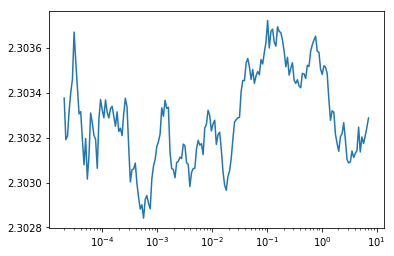

In [188]:
lrs, losses = learner.lr_find()
plot_lr(lrs, losses)

## Training phases and SGDR

A few helper functions. The second one is there to map the names of the hyper-parameters in pytorch optimizers to 'momentum' and 'beta' (whether it's SGD, Adam, RMSProp)

In [97]:
def is_tuple(x): return isinstance(x, tuple)

In [98]:
def set_val_in_group(val, group, key):
    if key == 'momentum' and 'betas' in group:  group['betas'] = (val, group['betas'][1])
    elif key == 'beta' and 'betas' in group:    group['betas'] = (group['betas'][0], val)
    elif key == 'beta' and 'alpha' in group:    group['alpha'] = val
    else:                                       group[key] = val

In [99]:
def set_val_in_groups(val, groups, key):
    for g in groups: set_val_in_group(val, g, key)

To simplify the use of training phase, the args lr and mom can either be:
- a single value, then it's assumed to have it constant during the phase
- a tuple (lr1, lr2), then the default is to go linearly from one to the other
- a tuple (lr1, lr2, VarType), then we go from one to the other using the VarType given.

In [100]:
class TrainingPhase():
    
    def __init__(self, epochs, opt_fn, hp_dict):
        self.epochs,self.opt_fn,self.beta,self.wds = epochs,opt_fn,beta,wds
        self.start_lr, self.end_lr, self.lr_vType, self.extra_lr = self.decode(lr)
        self.start_mom, self.end_mom, self.mom_vType, self.extra_mom = self.decode(mom)
        
    def decode(self, vals):
        if is_tuple(vals):
            if len(vals) == 2: return vals + (VarType.LINEAR, None)
            elif len(vals) == 3: return vals + (None,)
            else: return vals
        else: return vals, None, VarType.NO, None
    
    def get_scheds(self, opt, n_batch):
        if self.beta is not None: set_val_in_groups(self.beta, opt.param_groups, 'beta')
        if self.wds is not None: set_val_in_groups(self.wds, opt.param_groups, 'weight_decay')
        return [Scheduler(opt, 'lr', n_batch * self.epochs, self.lr_vType, self.start_lr, self.end_lr, self.extra_lr),
               Scheduler(opt, 'momentum', n_batch * self.epochs, self.mom_vType, self.start_mom, self.end_mom, self.extra_mom)]

In [101]:
LR = 'lr'
MOM = 'momentum'
WD = 'weight_decay'
BETA = 'beta'

In [102]:
class TrainingPhase1():
    
    def __init__(self, epochs, opt_fn, **kwargs):
        self.epochs,self.opt_fn = epochs,opt_fn
        assert 'LR' in kwargs, 'You need to set a learning rate.'
        self.hp_behavior = {self.rename(n):self.decode(v) for n,v in kwargs.items()}
        self.start_lr = self.hp_behavior[LR][0]
        
    def decode(self, vals):
        if is_tuple(vals):
            if len(vals) == 2: return vals + (annealing_linear, None)
            elif len(vals) == 3: return vals + (None,)
            else: return vals
        else: return vals, None, annealing_no, None
        
    def rename(self, name):
        match = {'LR':LR, 'MOM':MOM, 'WD':WD, 'BETA':BETA}
        return match[name] if name in match else name
    
    def get_scheds(self, opt, n_batch):
        return [HyperParamScheduler(opt, n, int(n_batch * self.epochs), v[2], v[0], v[1], v[3]) for n,v in self.hp_behavior.items()]

In [103]:
phase = TrainingPhase1(2, optim.SGD, LR=0.1, MOM=0.9, WD=1e-4)

The class that handles the phases and make sure we go from one to the next is another Callback.

In [104]:
class PhaseScheduler(LossRecorder):
    
    def __init__(self, model, phases, n_batches):
        self.model, self.phases, self.n_batches = model, phases, n_batches
        super().__init__()
        self.phase = 0
        self.opt = None
        self.init_phase()
    
    def on_train_begin(self):
        super().on_train_begin()
        self.hp_vals = collections.defaultdict(list)
    
    def init_phase(self):
        cur_phase = self.phases[self.phase]
        #Updates the optimizer
        #TODO: Replacing self.model.parameters() by a function that returns the trainable parameters will handle freezing.
        new_opt = cur_phase.opt_fn(self.model.parameters(), lr=cur_phase.start_lr)
        if self.opt is None or type(self.opt) != type(new_opt): self.opt = new_opt
        #Creates the various schedulers
        self.scheds = cur_phase.get_scheds(self.opt, self.n_batches)
        
    def on_batch_end(self, raw_loss):
        super().on_batch_end(raw_loss)
        finished = False
        for sched in self.scheds: finished = finished or sched.step()
        if finished:
            for sched in self.scheds: self.hp_vals[sched.hyper_param] += sched.vals
            self.phase += 1
            if self.phase == len(self.phases): return True
            self.init_phase()

fitting with phases is then super easy

In [105]:
def fit_phases(phases, model, loss_fn, train_dl, valid_dl=None, callbacks=[]):
    epochs = int(np.ceil(sum([p.epochs for p in phases])))
    cb = PhaseScheduler(model, phases, len(train_dl))
    fit(epochs, model, loss_fn, cb.opt, train_dl, valid_dl, callbacks=[cb])

An example of what a helper function could be.

In [106]:
def sgdr_phases(lr, opt_fn, n_cycle, cyc_len, cyc_mul, mom=0.9, wds=None):
    phases = [TrainingPhase(0.05, opt_fn, lr/100, mom, wds)]
    for i in range(n_cycle):
        epochs = cyc_len - 0.05 if i==0 else cyc_len * (cyc_mul ** i)
        phases.append(TrainingPhase(epochs, opt_fn, (lr,0,VarType.COSINE), mom, wds))
    return phases

In [107]:
def sgdr_phases1(lr, opt_fn, n_cycle, cyc_len, cyc_mul, mom=0.9, wds=None):
    phases = [TrainingPhase1(0.05, opt_fn, LR=lr/100, MOM=mom, WD=wds)]
    for i in range(n_cycle):
        epochs = cyc_len - 0.05 if i==0 else cyc_len * (cyc_mul ** i)
        phases.append(TrainingPhase1(epochs, opt_fn, LR=(lr,0,annealing_cos), MOM=mom, WD=wds))
    return phases

In [108]:
class Learner():
    def __init__(self, data, model):
        self.data,self.model = data,model.to(data.device)
        self.loss_fn = F.nll_loss

    def fit(self, epochs, lr, opt_fn=optim.SGD):
        opt = opt_fn(self.model.parameters(), lr=lr)
        fit(epochs, self.model, self.loss_fn, opt, self.data.train_dl, self.data.valid_dl)
    
    def fit_phases(self, phases, model, loss_fn, train_dl, valid_dl=None, callbacks=[]):
        epochs = int(np.ceil(sum([p.epochs for p in phases])))
        cb = PhaseScheduler(model, phases, len(train_dl))
        fit(epochs, model, loss_fn, cb.opt, train_dl, valid_dl, callbacks=[cb])
        self.hp_vals = cb.hp_vals
        
    def lr_find(self, opt_fn=optim.SGD, n_iter=200, start_lr=1e-5, end_lr=10):
        opt = opt_fn(self.model.parameters(), lr=start_lr)
        save_model(self.model, MODEL_PATH/'tmp.pt')
    
        cb = LRFinderCallback(opt, n_iter, start_lr, end_lr)
        epochs = int(np.ceil(n_iter/len(train_dl)))
        fit(epochs, self.model, self.loss_fn, opt, self.data.train_dl, callbacks=[cb])
    
        load_model(self.model, MODEL_PATH/'tmp.pt')
        return cb.sched.vals, cb.losses

In [134]:
data = DataBunch.from_arrays(x_train,y_train,x_valid,y_valid, x_tfms=mnist2image)
model = Simple_CNN([1,16,16,10], [3,3,3], [2,2,2])
learner = Learner(data, model)

In [135]:
learner.fit_phases(sgdr_phases1(0.5, optim.SGD, 3, 1, 2, wds=1e-4), model, loss_fn, data.train_dl, data.valid_dl)

0 0.7125297779083252
1 0.5471610698223114
2 0.45530813739299775
3 0.5599840276241302
4 0.4360611650466919
5 0.40436797997951507
6 0.3928226695775986


In [136]:
def accuracy(model, val_dl):
    n, c = 0, 0
    for xb,yb in val_dl:
        probs = model(xb)
        preds = probs.argmax(1)
        n += (preds==yb).long().sum().item()
        c += yb.size(0)
    return n / c

In [137]:
accuracy(learner.model, learner.data.valid_dl)

0.8636

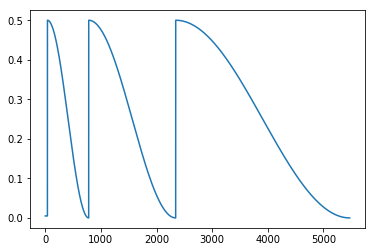

In [138]:
plt.plot(learner.hp_vals[LR])

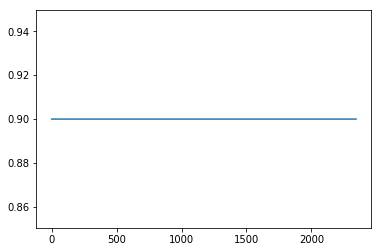

In [338]:
plt.plot(learner.hp_vals[MOM])

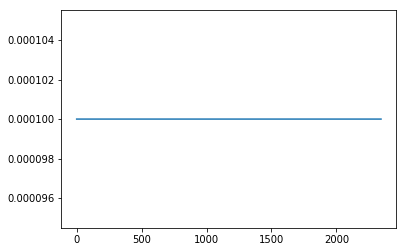

In [339]:
plt.plot(learner.hp_vals[WD])

# Darknet

In [29]:
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [30]:
class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        layers = [conv_layer(3, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x): return self.layers(x)

In [37]:
model = Darknet([1, 2, 4, 6, 3], num_classes=2, nf=32)
learner = Learner(data2, model)

In [38]:
learner.fit(1, 0.01, opt_fn=partial(optim.SGD, momentum=0.9))

0 0.7355462017059327


In [39]:
learner.fit(2, 0.05)

0 0.469083972454071


1 0.16272257494926454


In [40]:
learner.fit(1, 0.01)

0 0.14141892766952516


1 0.14167725318670274


# Sylvain's transforms

## Add transforms

In [57]:
from enum import IntEnum

class TfmType(IntEnum):
    NO = 1
    PIXEL = 2
    COORD = 3
    CLASS = 4

In [58]:
from abc import abstractmethod

class Transform():
    
    def __init__(self, tfm_y=TfmType.NO, p=1, batch_lvl = False):
        self.tfm_y,self.p,self.batch_lvl = tfm_y,p,batch_lvl
    
    def __call__(self, x, y):
        x,y = ((self.transform(x),y) if self.tfm_y==TfmType.NO
                else self.transform(x,y) if self.tfm_y in (TfmType.PIXEL, TfmType.CLASS)
                else self.transform_coord(x,y))
        return x, y
    
    def set_device(self, device):
        if not self.batch_lvl: self.device = device
    
    def transform_coord(self, x, y):
        if self.p == 1 or np.random.rand < self.p:
            return self.transform(x),y

    def transform(self, x, y=None):
        if self.p == 1 or np.random.rand < self.p:
            x = self.do_transform(x,False)
            return (x, self.do_transform(y,True)) if y is not None else x
        else: return x,y
    
    @abstractmethod
    def do_transform(self, x, is_y): raise NotImplementedError
    #In do_transform we can save a value (angle of a random rotation for instance) in self.save_for_y that will be used
    #if is_y is True.

In [60]:
class ChannelOrder(Transform):
    #If we use PIL for data augmentation, maybe the conversion to a numpy array should be handled here?
    def __init__(self, tfm_y=TfmType.NO):
        super().__init__(tfm_y=tfm_y)
    
    def do_transform(self, x, is_y):
        if not is_y or self.tfm_y == TfmType.PIXEL: x = np.rollaxis(x, 2)
        return x

In [61]:
class Normalize(Transform):
    
    def __init__(self, means, stds, tfm_y=TfmType.NO):
        self.means,self.stds = means,stds
        super().__init__(tfm_y=tfm_y, batch_lvl=True)
    
    def set_device(self, device):
        super().set_device(device)
        if type(self.means) != torch.Tensor or not self.means.device == device:
            self.means,self.stds = map(lambda x:torch.Tensor(x).to(device), (self.means, self.stds))
    
    def do_transform(self, x, is_y):
        if not is_y or self.tfm_y == TfmType.PIXEL:
            m, s = self.means[None,:,None,None].type_as(x), self.stds[None,:,None,None].type_as(x)
            x = (x - m) / s
        return x

In [62]:
def compose(tfms, x, y):
    for tfm in tfms: x,y = tfm(x,y)
    return x,y

In [84]:
def split_one_tfms(tfms):
    ds_tfms = [tfm for tfm in tfms if not tfm.batch_lvl]
    dl_tfms = [tfm for tfm in tfms if tfm.batch_lvl]
    return ds_tfms,dl_tfms
    
def split_tfms(trn_tfms, val_tfms):
    trn_ds_tfms, trn_dl_tfms = split_one_tfms(trn_tfms)
    val_ds_tfms, val_dl_tfms = split_one_tfms(val_tfms)
    return trn_ds_tfms, val_ds_tfms, trn_dl_tfms, val_dl_tfms